# Script to run Enrichment heatmap and Module scoring

# Import modules

In [1]:
import os.path
from pathlib import Path
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import scipy
import sys
import bbknn
import harmonypy as hm
from statsmodels import robust
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import gc
from scipy import stats
from scipy import sparse
import datetime
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis') # save plots at 300 dpi

In [2]:
adata = adata = sc.read('/Users/emilyjones/Desktop/HCA/project/script templates/raw counts/fbm_subset.h5ad') 
adata

AnnData object with n_obs × n_vars = 3612 × 33712
    obs: 'cell.labels', 'fetal.ids', 'gender', 'lanes', 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'processing.type', 'sequencing.type', 'sort.ids', 'broad_fig1_cell.labels', 'stage', 'cluster_categories', 'leiden'
    var: 'gene_ids-1', 'feature_types-1'
    uns: 'draw_graph', 'leiden', 'neighbors'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [3]:
adata = adata[adata.obs['cell.labels'].isin(['CD14 monocyte' ,'stromal macrophage', 'promonocyte'])] #'endosteal fibroblast', 'osteochondral precursor'
adata

View of AnnData object with n_obs × n_vars = 3612 × 33712
    obs: 'cell.labels', 'fetal.ids', 'gender', 'lanes', 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'processing.type', 'sequencing.type', 'sort.ids', 'broad_fig1_cell.labels', 'stage', 'cluster_categories', 'leiden'
    var: 'gene_ids-1', 'feature_types-1'
    uns: 'draw_graph', 'leiden', 'neighbors'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [4]:
adata.write('/Users/emilyjones/Desktop/HCA/project/script templates/raw counts/fbm_subset.h5ad')

# Import data

In [5]:
# if using more than 1 dataset to be compared with create combined object beforehand
# ideally import raw data into script which has scrublet already ran 

# Required: Introduce the path you'd like to save figures or data to 
save_path = "/Users/emilyjones/Desktop/HCA/project/script templates/raw counts/enrichment_score"

# Required: Name of first object
data1 = "fbm_myeloid"
# Provide path to obj1 // data to compare (DEGs to be calculated on)
Object1 = '/Users/emilyjones/Desktop/HCA/project/script templates/raw counts/fbm_myeloid.h5ad'
# Provide categorical to join between datasets
cat1 = 'cell.labels'

# Required: Name of second object
data2 = "mouse_data"
# Provide path to obj2 // prediction/projection data
Object2 = "/Users/emilyjones/Desktop/HCA/project/script templates/mouse/mouse_exp1_exp2_concat.h5ad"
# Provide categorical to join between datasets
cat2 = 'batch_id'

use_raw = True

Enrichment = True # Run enrichment module
Module_Score = True # Run module scoring module

Enrichment_DEG = True # If true will run Enrichment using DEG rarther than genes of interest

Genes_of_interest = True # If true and Enrichment_DEG is False will run enrichment scoring on genes of interest rarther than DEGs 
                         # required True for running each category being a different gene list aswell
                         # True required for Module Scoring 

Manual_genes_interest_each_category = False # select True if inserting genes manually/importing genes for each individual celltype instead of same list for all celltypes 

CSV_import_genes = False # CSV requires 1 column labelled "Celltype" and 1 column labelled "Genes" with data in a Long format
# Provide path to csv file
CSV = ""

# Note if both Enrichment_DEG and Genes_of_interest are selected it will run DEGs for enrichment 
# but genes of interest for module scoring 

remove_non_high_var = False 
Genes_of_interest_list = ['ACKR1', 'SNCG'] # to insert list use ['',''] ... for genes or import predetermined list, to have unique genes of interest for each category for enrichment module see cell X

# Prep objects 

In [6]:
%%time
# Check if filepaths are good
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
if (Path(Object1).is_file() & Path(Object2).is_file()):
    print("adata file paths detetcted, proceeding to load")
    adata1 = sc.read(Object1)
    adata2 =  sc.read(Object2)
    del adata1.uns
    del adata2.uns
else: 
    raise TypeError("one or more .h5ad paths cannot be accessed")

# altering scanpy setting so that we can save it to our defined directory
sc._settings.ScanpyConfig(figdir=save_path)

# Module to detect shape mismatch and alternatively rebuild adata
if(use_raw==True):
    print('option detected to use raw data, proceeding to check if raw exists and if it matches data.X')
    if (hasattr(adata1.raw, "X")):
        try: adata1.X =  adata1.raw.X  ; print('no mismatch in shape for adata detected')
        except: print("adata1.X shape mismatched with adata1.raw.X, proceeding to re-build data") ; adata = adata.raw.to_adata()
    else:
        print("no raw data detected in adata1! proceeding to create raw partition from adata1.X")
        adata1.raw = adata1
        
    if (hasattr(adata2.raw, "X")):
        try: adata2.X = adata2.raw.X ; print('no mismatch in shape for adata2 detected')
        except: print("adata2.X shape mismatched with adata.raw.X, proceeding to re-build data") ; adata2 = adata2.raw.to_adata()
    else:
        print("no raw data detected in adata! proceeding to create raw partition from adata.X")
        adata2.raw = adata2
            

# Create a common obs column in both datasets containing the data origin tag
common_cat = "corr_concat" 
adata1.obs[common_cat] = adata1.obs[cat1].astype(str) + data1
adata2.obs[common_cat] = adata2.obs[cat2].astype(str) + data2
adata1.obs = adata1.obs.astype('category')
adata2.obs = adata2.obs.astype('category')
    
print("Preparation complete")

adata file paths detetcted, proceeding to load
option detected to use raw data, proceeding to check if raw exists and if it matches data.X
no raw data detected in adata1! proceeding to create raw partition from adata1.X
no raw data detected in adata! proceeding to create raw partition from adata.X
Preparation complete
CPU times: user 249 ms, sys: 78.4 ms, total: 327 ms
Wall time: 331 ms


In [7]:
adata2.var.index = adata2.var['symbol']
adata2.var_names

Index(['IFNLR1', 'ORAI3', 'DNAH14', 'FLT4', 'BTNL2', 'FAM118A', 'LGR5',
       'ANXA1', 'AMD1', 'JPX',
       ...
       'CNTF', 'DNAL1', 'DHX37', 'ZSCAN2', 'MAMSTR', 'NOM1', 'S100A4', 'PTOV1',
       'TFCP2', 'NAMPT'],
      dtype='object', name='symbol', length=10957)

In [8]:
adata.shape

(3612, 33712)

In [9]:
adata2.shape

(20, 10957)

In [10]:
# Define intersecting genes between datasets
adata_genes = list(adata.var.index)
adata2_genes = list(adata2.var.index)
keep_SC_genes = list(set(adata_genes) & set(adata2_genes))
print("keep gene list = " , len(keep_SC_genes), "adata1 gene length = ", len(adata_genes) , "adata2 gene length = ", len(adata2_genes) )

# Remove non-intersecting genes (this step will remove cite-seq data if training data is pure RNA seq)
adata_intersect1 = adata[:, keep_SC_genes]
adata = adata_intersect1
adata_intersect2 = adata2[:, keep_SC_genes]
adata2 = adata_intersect2

keep gene list =  10531 adata1 gene length =  33712 adata2 gene length =  10957


In [11]:
adata.shape

(3612, 10531)

In [12]:
adata2.shape

(20, 10531)

# Enrichment Module

In [13]:
if (Enrichment == True) & (Enrichment_DEG == True):
    print("Enrichment option selected and to run on DEGs selected, proceed to run all following Enrichment module cells")
    DEG_data = adata
    #DEG_data = sc.read(Object1)
    datashape = DEG_data.shape
    print(f"DEG_data shape: {datashape} ")
elif (Enrichment == True) & (Enrichment_DEG == False) & (Genes_of_interest == True):
    print("Enrichment option selected and running on selected genes of interest, proceed to dictionary cell")
    DEG_data = adata
    #DEG_data = sc.read(Object1)
    datashape = DEG_data.shape
    print(f"DEG_data shape: {datashape} ")
else:
    print("Enrichment option not selected or seetings inputted incorrect, proceed to module scoring section or recheck input settings")

Enrichment option selected and to run on DEGs selected, proceed to run all following Enrichment module cells
DEG_data shape: (3612, 10531) 


In [14]:
cell_numbers = DEG_data.obs.groupby(cat1).apply(len)
cell_numbers

cell.labels
CD14 monocyte         1763
promonocyte           1508
stromal macrophage     341
dtype: int64

In [15]:
# check if data array is sparse or not
DEG_data.X

<3612x10531 sparse matrix of type '<class 'numpy.float32'>'
	with 6483571 stored elements in Compressed Sparse Row format>

In [16]:
# line added in due to array not being in sparse format so the next cell will work for mito genes section
DEG_data.X = sparse.csr_matrix(DEG_data.X)

In [17]:
# add the total counts per cell as observations-annotation to adata
DEG_data.obs['nUMI'] = DEG_data.X.sum(axis=1)
sc.pp.calculate_qc_metrics(DEG_data, var_type='genes', layer=None, use_raw=False, inplace=True, parallel=None)
DEG_data.obs["nGene"] = DEG_data.obs["n_genes_by_counts"]

del DEG_data.obs["n_genes_by_counts"]
del DEG_data.obs["log1p_n_genes_by_counts"]
del DEG_data.obs["log1p_total_counts"]
del DEG_data.obs["total_counts"]
del DEG_data.obs["pct_counts_in_top_50_genes"]
del DEG_data.obs["pct_counts_in_top_100_genes"]
del DEG_data.obs["pct_counts_in_top_200_genes"]
del DEG_data.obs["pct_counts_in_top_500_genes"]
del DEG_data.var["n_cells_by_counts"]
del DEG_data.var["mean_counts"]
del DEG_data.var["log1p_mean_counts"]
del DEG_data.var["pct_dropout_by_counts"]
del DEG_data.var["total_counts"]
del DEG_data.var["log1p_total_counts"]

if 'gene_ids' in DEG_data.var.columns:
    del DEG_data.var['gene_ids']

# filter for genes in at least 3 cells and cells with at least 200 genes 
sc.pp.filter_cells(DEG_data, min_genes=200) # Keep all cells with at least 200 detected genes
sc.pp.filter_genes(DEG_data, min_cells=3) # Keep all genes expressed in >= 3 cells. 

mito_genes = DEG_data.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
DEG_data.obs['percent.mito'] = np.sum(DEG_data[:, mito_genes].X, axis=1).A1 / np.sum(DEG_data.X, axis=1).A1
DEG_data = DEG_data[DEG_data.obs['percent.mito'] < 0.2, :]
DEG_data.shape

Trying to set attribute `.obs` of view, copying.


filtered out 6 cells that have less than 200 genes expressed
filtered out 825 genes that are detected in less than 3 cells


(3606, 9706)

In [18]:
DEG_data.var_names

Index(['ZKSCAN7', 'TICRR', 'BLCAP', 'ZYG11B', 'PFDN6', 'FRYL', 'LEMD3',
       'RIMS3', 'SNN', 'CDK2',
       ...
       'CLP1', 'IDH1', 'BAMBI', 'B4GALT1', 'RGL2', 'TRPM7', 'MBD4', 'GNG10',
       'NMI', 'SLC25A3'],
      dtype='object', length=9706)

In [19]:
# normalise count data 
sc.pp.normalize_total(DEG_data)
# log the count data 
sc.pp.log1p(DEG_data)
# find variable genes
sc.pp.highly_variable_genes(DEG_data, min_mean=0.0125, max_mean=3, min_disp=0.5) 
# scale the data 
sc.pp.scale(DEG_data, max_value=10)
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
DEG_data.X = np.where(DEG_data.X < 0, 0, DEG_data.X)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/Applications/anaconda3/envs/python_1.8.1/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [20]:
if (Enrichment == True) & (Enrichment_DEG == False) & (Genes_of_interest == True):
    print("Option to run genes of interest selected, look at plotting heatmap output")
else:
    sc.tl.rank_genes_groups(DEG_data, groupby= cat1, method='wilcoxon', use_raw=False, log_transformed=True, n_genes=1000)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


In [21]:
if (Enrichment == True) & (Enrichment_DEG == False) & (Genes_of_interest == True):
    print("Option to run genes of interest selected, look at plotting heatmap output")
else:
    sc.tl.filter_rank_genes_groups(DEG_data, min_in_group_fraction=0.25, min_fold_change=0.25, use_raw=False)

Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 0.25, max_out_group_fraction: 0.5


In [22]:
#to set unique date for results
calc_date = datetime.datetime.now()
date=calc_date.strftime('%Y-%m-%d')
date = date.replace('-', '')

# save df for unfiltered degs
result = DEG_data.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals', 'logfoldchanges']})

# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
p = Path(save_path)
degs_by_cluster.to_csv(Path(p,'Enrichment_DEG_data_' + date +'.csv'))
degs_by_cluster[:10]

,CD14 monocyte_n,CD14 monocyte_p,CD14 monocyte_l,promonocyte_n,promonocyte_p,promonocyte_l,stromal macrophage_n,stromal macrophage_p,stromal macrophage_l
0,S100A6,2.069393e-241,2.108146,MPO,1.113718e-242,5.623315,C1QC,1.865726e-182,9.688942
1,CTSS,3.484460e-240,3.143181,PTMA,1.647415e-235,2.367512,NPC2,6.457645e-180,4.637415
2,JAML,2.421904e-234,3.517143,HMGB1,2.355161e-230,2.868219,SPP1,4.604214e-173,9.457891
3,CD37,1.425882e-220,2.818236,RETN,3.085598e-207,2.127694,C1QB,9.010761e-169,9.440303
4,FPR1,4.994128e-198,3.359421,DEK,7.035583e-207,2.646357,APOC1,5.114848e-162,9.718989
5,PLBD1,2.379958e-191,2.692288,HMGN2,1.539798e-202,2.448656,C1QA,1.313190e-159,9.069981
6,IFITM2,3.346747e-189,3.158030,STMN1,2.625132e-192,2.669255,LGMN,1.350579e-154,8.533050
7,NACA,1.497515e-180,2.213953,TUBA1B,2.534549e-179,2.654891,PSAP,7.236689e-151,3.570214
8,CD52,2.082029e-179,2.271655,MKI67,7.899790e-175,3.583632,FOLR2,9.927444e-151,7.380648
9,VCAN,3.567349e-170,2.087700,PLAC8,1.268683e-174,2.289053,APOE,2.193093e-146,9.686461


In [23]:
degs_by_cluster_filtered = pd.read_csv('/Users/emilyjones/Desktop/HCA/project/script templates/raw counts/enrichment_score/Enrichment_DEG_data_20210901.csv')

In [13]:
#to set unique date for results
calc_date = datetime.datetime.now()
date=calc_date.strftime('%Y-%m-%d')
date = date.replace('-', '')

# save df for filtered degs
result = DEG_data.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
degs_by_cluster_filtered = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals', 'logfoldchanges']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
p = Path(save_path)
degs_by_cluster.to_csv(Path(p,'Enrichment_DEG_data_filtered_' + date +'.csv'))
degs_by_cluster_filtered[:10]

,AEC_n,AEC_p,AEC_l,EC_n,EC_p,EC_l,Endo_n,Endo_p,Endo_l,Epi_n,...,Meso_T+_l,Meso_TBX6+_n,Meso_TBX6+_p,Meso_TBX6+_l,Myocyte_n,Myocyte_p,Myocyte_l,PGC_like_n,PGC_like_p,PGC_like_l
0,RAMP2,2.412650e-45,5.791131,EGFL7,1.289259e-106,4.935738,RAMP2,0.0,6.147596,FGB,...,4.566658,FABP5,0.0,3.654791,TNNT2,2.233401e-79,11.585414,POU5F1,5.563369e-35,15.511828
1,GJA5,3.294283e-42,11.154903,RAMP2,4.074749e-106,5.708071,PLVAP,0.0,6.532812,CKB,...,4.496517,MEST,0.0,3.999453,MYL7,2.277263e-79,13.092622,TCL1A,5.569245e-35,19.496393
2,TFPI,4.273889e-42,6.173187,PRCP,7.281582e-105,5.169253,ECSCR,0.0,6.829685,APOA1,...,4.713308,LAPTM4B,0.0,2.856626,TNNI1,2.560418e-79,11.007673,PCSK1N,5.905170e-35,16.882217
3,TM4SF1,2.757836e-40,9.773716,NRP2,1.026382e-103,5.206005,VAMP5,0.0,5.536121,CLDN6,...,3.747427,DLL3,0.0,4.391029,MYL4,2.945975e-79,11.590236,NaN,1.678563e-34,5.645722
4,HSPG2,6.523134e-40,7.533913,IGFBP4,3.657332e-103,4.382476,GNG11,0.0,5.779959,S100A10,...,3.739719,CXCR4,0.0,3.215373,ACTC1,3.355760e-79,10.666210,NaN,2.134552e-34,5.280027
5,ECSCR,2.047630e-39,5.866606,EMCN,6.047391e-103,7.899303,ESAM,0.0,6.703077,LGALS3,...,4.615941,HOXB-AS3,0.0,2.614328,TPM1,1.089078e-77,5.157773,NaN,3.540809e-34,5.183226
6,PECAM1,2.556433e-39,6.796069,TFPI,4.069508e-101,5.535852,EGFL7,0.0,4.582983,NaN,...,2.385757,SMC6,0.0,3.200774,MYL9,3.663517e-76,6.438760,NaN,4.703293e-34,5.105197
7,GJA4,3.745304e-39,7.200735,MEF2C,4.505447e-100,5.572707,TFPI,0.0,5.238178,EPCAM,...,4.201054,LEF1,0.0,3.077514,TNNC1,6.309339e-76,11.464659,NaN,8.060673e-34,4.597861
8,CLEC14A,4.238160e-39,12.066788,HSPB1,1.351854e-99,4.122303,IGFBP4,0.0,4.193860,AFP,...,5.714595,AIF1,0.0,3.017820,NKX2-5,4.297520e-75,14.564546,NaN,8.423876e-34,5.619256
9,NaN,4.600253e-39,4.036940,CDH5,7.957631e-98,6.349550,CDH5,0.0,6.586100,VTN,...,3.192287,HOXB9,0.0,2.447746,CRIP1,2.989715e-73,7.838926,NANOS3,1.549128e-33,15.534694


In [25]:
cell_numbers = DEG_data.obs.groupby(cat1).apply(len)
cell_numbers

cell.labels
CD14 monocyte         1763
promonocyte           1503
stromal macrophage     340
dtype: int64

## Save top 100 filtered DEGs within dictionary

In [24]:
# sort the degs_by_cluster_filtered df genes by logfc
df = degs_by_cluster_filtered
df[:5]

,Unnamed: 0,CD14 monocyte_n,CD14 monocyte_p,CD14 monocyte_l,promonocyte_n,promonocyte_p,promonocyte_l,stromal macrophage_n,stromal macrophage_p,stromal macrophage_l
0,0,S100A6,2.069393e-241,2.108146,MPO,1.113718e-242,5.623315,C1QC,1.865726e-182,9.688942
1,1,CTSS,3.484460e-240,3.143181,PTMA,1.647415e-235,2.367512,NPC2,6.457645e-180,4.637415
2,2,JAML,2.421904e-234,3.517143,HMGB1,2.355161e-230,2.868219,SPP1,4.604214e-173,9.457890
3,3,CD37,1.425882e-220,2.818236,RETN,3.085598e-207,2.127694,C1QB,9.010761e-169,9.440303
4,4,FPR1,4.994128e-198,3.359421,DEK,7.035583e-207,2.646357,APOC1,5.114848e-162,9.718989


## Dictionary

In [29]:
my_dict

{'CD14 monocyte_degs': ['AQP9',
  'CLEC4E',
  'CD300E',
  'JAML',
  'TNFRSF8',
  'ORM1',
  'FPR1',
  'ORM2',
  'LILRA5',
  'CREB5',
  'IFITM2',
  'CTSS',
  'ECE1',
  'SMARCD3',
  'SLC11A1',
  'CD37',
  'ADGRG3',
  'PGLYRP1',
  'CD55',
  'PLBD1'],
 'promonocyte_degs': ['MPO',
  'TICRR',
  'PRTN3',
  'RECQL4',
  'MCM10',
  'CDCA5',
  'E2F8',
  'PKMYT1',
  'MYBL2',
  'FOXM1',
  'IQGAP3',
  'FANCI',
  'NCAPG',
  'CDT1',
  'CENPM',
  'KIF11',
  'RRM2',
  'CDC6',
  'RAD51',
  'MELK'],
 'stromal macrophage_degs': ['SLC22A23',
  'ANTXR1',
  'TREM2',
  'APOC1',
  'C1QC',
  'APOE',
  'FABP3',
  'ITGB5',
  'SPP1',
  'C1QB',
  'MSR1',
  'C1QA',
  'HSD17B14',
  'CXCL12',
  'RAMP1',
  'SLCO2B1',
  'EBI3',
  'GPNMB',
  'LGMN',
  'CD28']}

In [30]:
df = pd.DataFrame(my_dict)
df

,CD14 monocyte_degs,promonocyte_degs,stromal macrophage_degs
0,AQP9,MPO,SLC22A23
1,CLEC4E,TICRR,ANTXR1
2,CD300E,PRTN3,TREM2
3,JAML,RECQL4,APOC1
4,TNFRSF8,MCM10,C1QC
5,ORM1,CDCA5,APOE
6,FPR1,E2F8,FABP3
7,ORM2,PKMYT1,ITGB5
8,LILRA5,MYBL2,SPP1
9,CREB5,FOXM1,C1QB


In [31]:
df.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
CD14 monocyte_degs,AQP9,CLEC4E,CD300E,JAML,TNFRSF8,ORM1,FPR1,ORM2,LILRA5,CREB5,IFITM2,CTSS,ECE1,SMARCD3,SLC11A1,CD37,ADGRG3,PGLYRP1,CD55,PLBD1
promonocyte_degs,MPO,TICRR,PRTN3,RECQL4,MCM10,CDCA5,E2F8,PKMYT1,MYBL2,FOXM1,IQGAP3,FANCI,NCAPG,CDT1,CENPM,KIF11,RRM2,CDC6,RAD51,MELK
stromal macrophage_degs,SLC22A23,ANTXR1,TREM2,APOC1,C1QC,APOE,FABP3,ITGB5,SPP1,C1QB,MSR1,C1QA,HSD17B14,CXCL12,RAMP1,SLCO2B1,EBI3,GPNMB,LGMN,CD28


In [26]:
if ((Enrichment == True) & (Enrichment_DEG == False) & (Genes_of_interest == True) & (Manual_genes_interest_each_category == False)):
    new_anno = cat1+'_genes_of_interest'
    DEG_data.obs[new_anno] = DEG_data.obs[cat1].astype(str) + '_genes_of_interest'
    anno_labels = DEG_data.obs.iloc[: , -1].unique()
    my_dict = dict.fromkeys(anno_labels, Genes_of_interest_list)

elif ((Enrichment == True) & (Enrichment_DEG == False) & (Genes_of_interest == True) & (Manual_genes_interest_each_category == True)):
    new_anno = cat1+'_genes_of_interest'
    adata.obs[new_anno] = adata.obs[cat1].astype(str) + '_genes_of_interest'
    anno_labels = adata.obs.iloc[: , -1].unique()
    print("Manual gene input selected, in the next cell insert genes into dictionary for each unique cell type listed below:")
    print(anno_labels)

else:
    my_dict = {}
    for i in DEG_data.obs[cat1].unique().tolist():
        # for each DEG list
        print(i)
        # assign cols
        gene_name = str(i) + "_n"
        logfc = str(i) + "_l"
        
        # sort values of genes based on logfc
        df = df.sort_values([logfc], ascending=False)
        gene_list = df[gene_name].tolist()
        # remove nan values from genes
        cleanedList = [x for x in gene_list if str(x) != 'nan']
        #get top 20 genes
        top_20_genes = cleanedList[:20] 
        # save 20 degs as values in key named "celltype"_degs
        x = str(i) + "_degs"
        my_dict[x] = top_20_genes
    if 'nan_degs' in my_dict:
            del my_dict['nan_degs']

CD14 monocyte
promonocyte
stromal macrophage


In [27]:
if ((Enrichment == True) & (Enrichment_DEG == False) & (Genes_of_interest == True) & (Manual_genes_interest_each_category == True) & (CSV_import_genes == False)):
    # super manual - make sure categories match listed above exactly
    my_dict = {'celltype1': ['gene1','gene2','gene3'],
               'celltype2' : ['gene1','gene2','gene3'] #... continue pattern downwards for each celltype and genes of interest
              }
# option to import csv for universal method - note make sure csv is in correct format with column for celltype and column for genes 
elif ((Enrichment == True) & (Enrichment_DEG == False) & (Genes_of_interest == True) & (Manual_genes_interest_each_category == True) & (CSV_import_genes == True)):
    anno_csv_data = pd.read_csv(CSV)
    my_dict = anno_csv_data.groupby('Celltype')['Genes'].agg(list).to_dict()

else:
    print("Manual genes for each category not inputted or needed")

Manual genes for each category not inputted or needed


In [28]:
my_dict.keys()

dict_keys(['CD14 monocyte_degs', 'promonocyte_degs', 'stromal macrophage_degs'])

In [32]:
# if have multiple datasets load in here and copy following cells editing adata to be new data values 

In [36]:
adata = adata2

In [37]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata)
adata.X = np.where(adata.X <0, 0, adata.X)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/Applications/anaconda3/envs/python_1.8.1/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [38]:
adata.var

,symbol,biotype,chromosome,start,stop,HGNC_orth,mouse_ens_id,CCR1_mean-0,CCR2_mean-0,CCR1_median-0,...,CCR5_median-1,NO_CCR_median-1,CCR5_stdev-1,NO_CCR_stdev-1,highly_variable,means,dispersions,dispersions_norm,mean,std
symbol,,,,,,,,,,,,,,,,,,,,,
ZKSCAN7,ZKSCAN7,GENE,9,122714750,122727683,ZKSCAN7,ENSMUSG00000063488,16.0425,23.9075,15.685,...,36.45,21.58,15.869237,14.078557,False,3.037061,2.424487,-0.727417,2.788331,0.763631
TICRR,TICRR,GENE,7,79309944,79347896,TICRR,ENSMUSG00000046591,509.8600,231.8825,483.645,...,46.80,31.39,19.292970,16.586412,False,4.627928,4.525853,0.703448,4.126255,1.132059
BLCAP,BLCAP,GENE,2,157398282,157413194,BLCAP,ENSMUSG00000067787,437.9725,699.1925,439.000,...,473.89,665.36,69.504160,43.194139,False,6.123681,4.233563,-0.352789,6.046514,0.413341
ZYG11B,ZYG11B,GENE,4,108086921,108158293,ZYG11B,ENSMUSG00000034636,665.0700,718.0750,671.880,...,678.99,450.17,93.709121,72.746896,False,6.253888,4.100838,-0.807450,6.201466,0.328766
PFDN6,PFDN6,GENE,17,34157795,34159317,PFDN6,ENSMUSG00000024309,2781.4750,2431.6525,2826.235,...,150.19,86.08,33.369543,7.560019,False,6.435841,6.376563,1.108061,5.852645,1.145557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRPM7,TRPM7,GENE,2,126633485,126718150,TRPM7,ENSMUSG00000027365,2296.1125,1906.2150,2362.195,...,1320.96,1898.38,361.598676,362.650489,False,7.373800,5.425747,-0.585081,7.310201,0.362727
MBD4,MBD4,GENE,6,115817658,115830332,MBD4,ENSMUSG00000030322,860.4750,615.4275,829.135,...,70.55,58.16,10.670467,18.988785,False,5.245234,5.006291,0.754226,4.821272,0.960692
GNG10,GNG10,GENE,4,59035088,59041903,GNG10,ENSMUSG00000038607,300.3725,269.2225,309.365,...,4.19,2.51,0.940118,1.180687,False,4.150143,4.417409,0.925932,3.041016,1.703126


In [39]:
#adata.var.index = adata.var['symbol']
#adata.var_names

In [40]:
# run through DEG list / genes of interest list (for ease also labelled DEG_lists in this cell) for each cell type, run score_genes function on adata object for these genes and save in .obs
celltypes_string_list = list(my_dict.keys())

DEG_lists = list(my_dict.values())
counter = 0

for i in DEG_lists:
    sc.tl.score_genes(adata, gene_list = i , score_name = celltypes_string_list[counter], use_raw = False)
    counter = counter + 1

computing score 'CD14 monocyte_degs'
    finished: added
    'CD14 monocyte_degs', score of gene set (adata.obs).
    746 total control genes are used. (0:00:00)
computing score 'promonocyte_degs'
    finished: added
    'promonocyte_degs', score of gene set (adata.obs).
    596 total control genes are used. (0:00:00)
computing score 'stromal macrophage_degs'
    finished: added
    'stromal macrophage_degs', score of gene set (adata.obs).
    697 total control genes are used. (0:00:00)


### re-order annotation columns here if required

In [41]:
# check current order
adata.obs["corr_concat"].unique()

['CCR1_exp_2mouse_data', 'CCR2_exp_2mouse_data', 'CCR1_exp_1mouse_data', 'CCR2_exp_1mouse_data', 'CCR5_exp_1mouse_data', 'NO_CCR_exp_1mouse_data']
Categories (6, object): ['CCR1_exp_1mouse_data', 'CCR1_exp_2mouse_data', 'CCR2_exp_1mouse_data', 'CCR2_exp_2mouse_data', 'CCR5_exp_1mouse_data', 'NO_CCR_exp_1mouse_data']

In [42]:
# reset order

adata.obs["corr_concat_str"] = adata2.obs["corr_concat"].astype("category")

adata.obs["corr_concat_str"] = adata.obs["corr_concat_str"].cat.reorder_categories(['CCR2_exp_2mouse_data', 'CCR1_exp_2mouse_data', 'CCR1_exp_1mouse_data', 'CCR2_exp_1mouse_data', 'CCR5_exp_1mouse_data', 'NO_CCR_exp_1mouse_data'])
       
    
    
       #'ys_Monocyte',  
       #'liver_CD14 monocyte', 'liver_DC precursor', 'liver_DC1', 'liver_DC2', 'liver_pDC precursor',
       #'fbm_CD14 monocyte', 'fbm_DC precursor', 'fbm_DC1', 'fbm_DC2', 'fbm_DC3', 'fbm_pDC', 'fbm_tDC',
       #'abm_CD14 monocyte', 'abm_CD16 monocyte', 'abm_monocyte-DC',
       #'abm_DC precursor', 'abm_DC1', 'abm_DC2', 'abm_DC3', 'abm_pDC', 'abm_tDC'])

In [43]:
# check re-ordering
adata.obs["corr_concat_str"].unique()

['CCR1_exp_2mouse_data', 'CCR2_exp_2mouse_data', 'CCR1_exp_1mouse_data', 'CCR2_exp_1mouse_data', 'CCR5_exp_1mouse_data', 'NO_CCR_exp_1mouse_data']
Categories (6, object): ['CCR2_exp_2mouse_data', 'CCR1_exp_2mouse_data', 'CCR1_exp_1mouse_data', 'CCR2_exp_1mouse_data', 'CCR5_exp_1mouse_data', 'NO_CCR_exp_1mouse_data']

### continue script

In [44]:
# save cell cycle scores within metadata as a dataframe (called enrichement scores)
adata.obs["labels"] = adata.obs["corr_concat_str"]
meta = pd.DataFrame(adata.obs)
number_of_celltypes = len(my_dict.keys())
columns_to_keep = number_of_celltypes + 2
enrichment_scores_df = meta[meta.columns[-columns_to_keep:]]
enrichment_scores_df

,CD14 monocyte_degs,promonocyte_degs,stromal macrophage_degs,corr_concat_str,labels
CCR1_R1_exp_2,-0.132498,0.678956,-0.432551,CCR1_exp_2mouse_data,CCR1_exp_2mouse_data
CCR1_R2_exp_2,-0.192239,0.770230,-0.406177,CCR1_exp_2mouse_data,CCR1_exp_2mouse_data
CCR1_R3_exp_2,-0.047102,0.722855,-0.331372,CCR1_exp_2mouse_data,CCR1_exp_2mouse_data
CCR1_R4_exp_2,-0.147660,0.797791,-0.383784,CCR1_exp_2mouse_data,CCR1_exp_2mouse_data
CCR2_R1_exp_2,0.007945,0.107089,-0.326117,CCR2_exp_2mouse_data,CCR2_exp_2mouse_data
CCR2_R2_exp_2,-0.122144,0.385970,-0.351399,CCR2_exp_2mouse_data,CCR2_exp_2mouse_data
CCR2_R3_exp_2,-0.020544,0.258043,-0.291872,CCR2_exp_2mouse_data,CCR2_exp_2mouse_data
CCR2_R4_exp_2,-0.008705,0.060015,-0.298851,CCR2_exp_2mouse_data,CCR2_exp_2mouse_data
CCR1_R1_exp_1,-0.019153,-0.265442,0.340287,CCR1_exp_1mouse_data,CCR1_exp_1mouse_data
CCR1_R2_exp_1,-0.069135,-0.189242,0.245870,CCR1_exp_1mouse_data,CCR1_exp_1mouse_data


In [45]:
# calculate mean enrichment scores by celltype
mean_enrichment_scores_df = enrichment_scores_df.groupby('labels').mean()
mean_enrichment_scores_df = mean_enrichment_scores_df.T
mean_enrichment_scores_df = mean_enrichment_scores_df.sort_index()
mean_enrichment_scores_df

labels,CCR2_exp_2mouse_data,CCR1_exp_2mouse_data,CCR1_exp_1mouse_data,CCR2_exp_1mouse_data,CCR5_exp_1mouse_data,NO_CCR_exp_1mouse_data
CD14 monocyte_degs,-0.035862,-0.129875,-0.025274,0.298851,-0.076069,0.010803
promonocyte_degs,0.202779,0.742458,-0.240823,-0.358460,-0.277172,-0.374816
stromal macrophage_degs,-0.317059,-0.388471,0.288143,0.039082,0.304883,0.256885


## Heatmap output

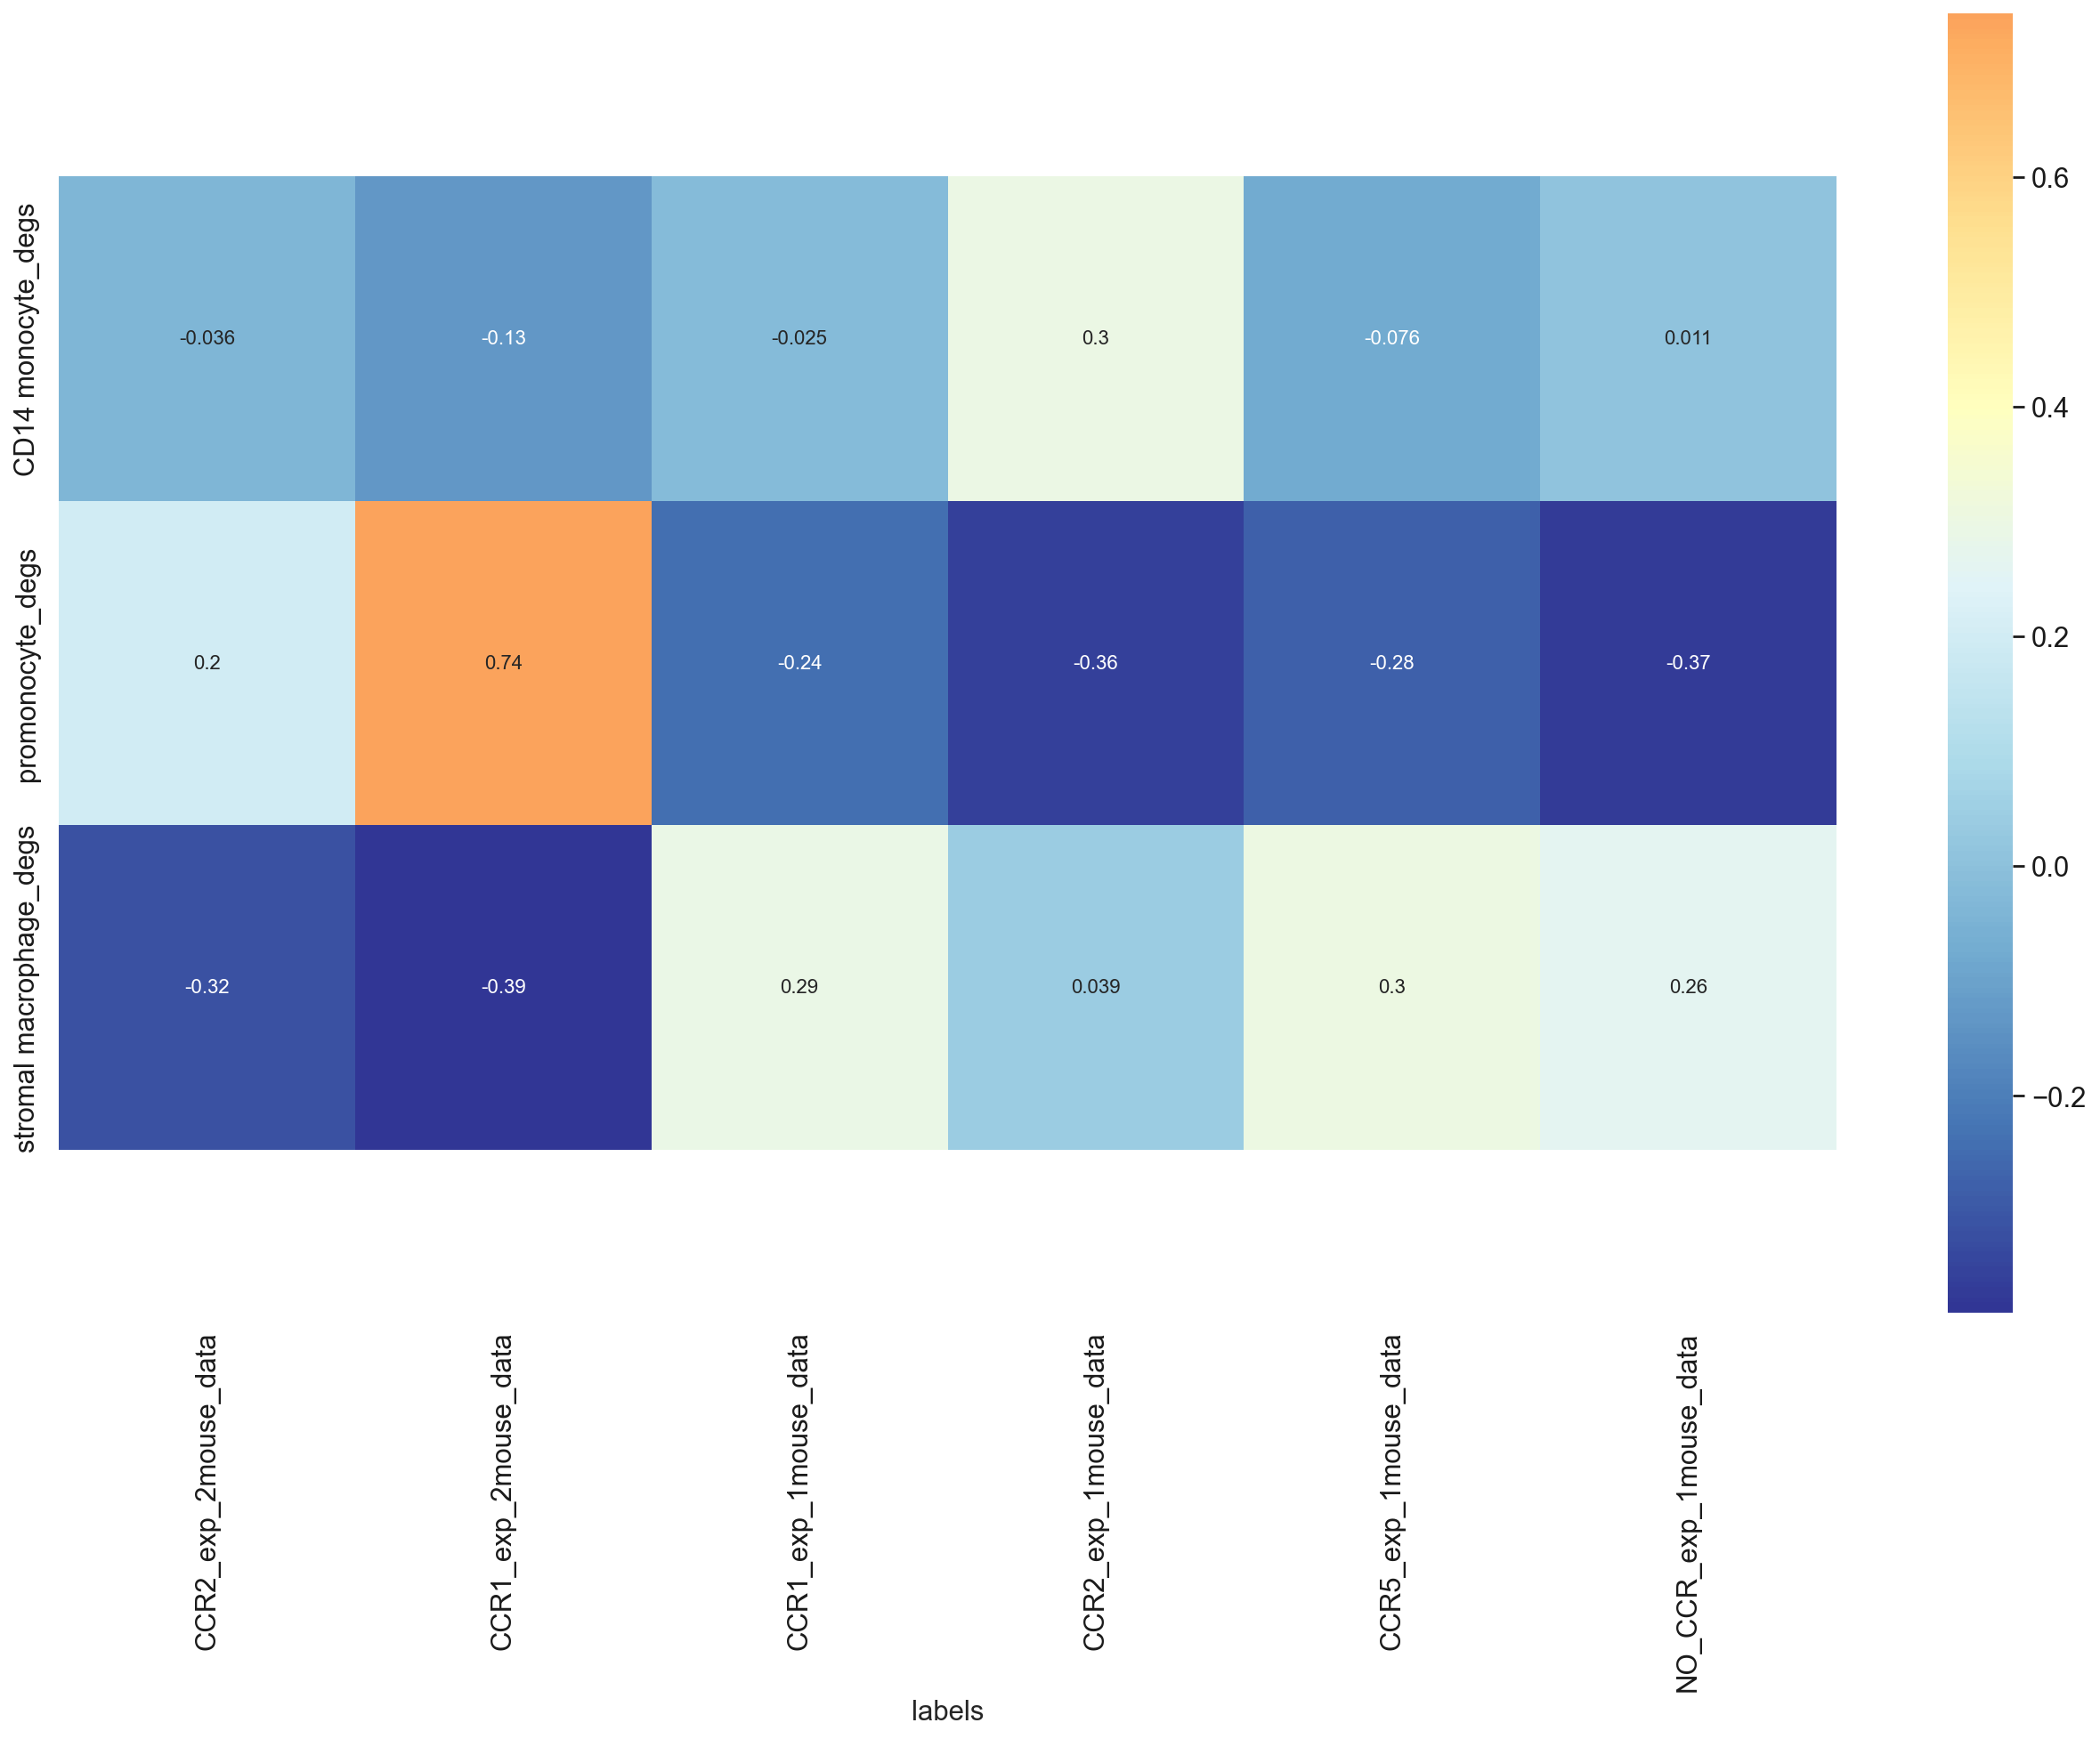

In [46]:
plt.figure(figsize=(20, 12))
fig = sns.heatmap(mean_enrichment_scores_df, annot=True, fmt=".2", center=0.4, annot_kws={"size": 10}, cmap="RdYlBu_r").get_figure() #xticklabels=cell_label_order, yticklabels=cell_label_order,
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
#fig.savefig("figures/figs2e_dc_blood_comparison_numbers_yes_20210111.pdf")
fig

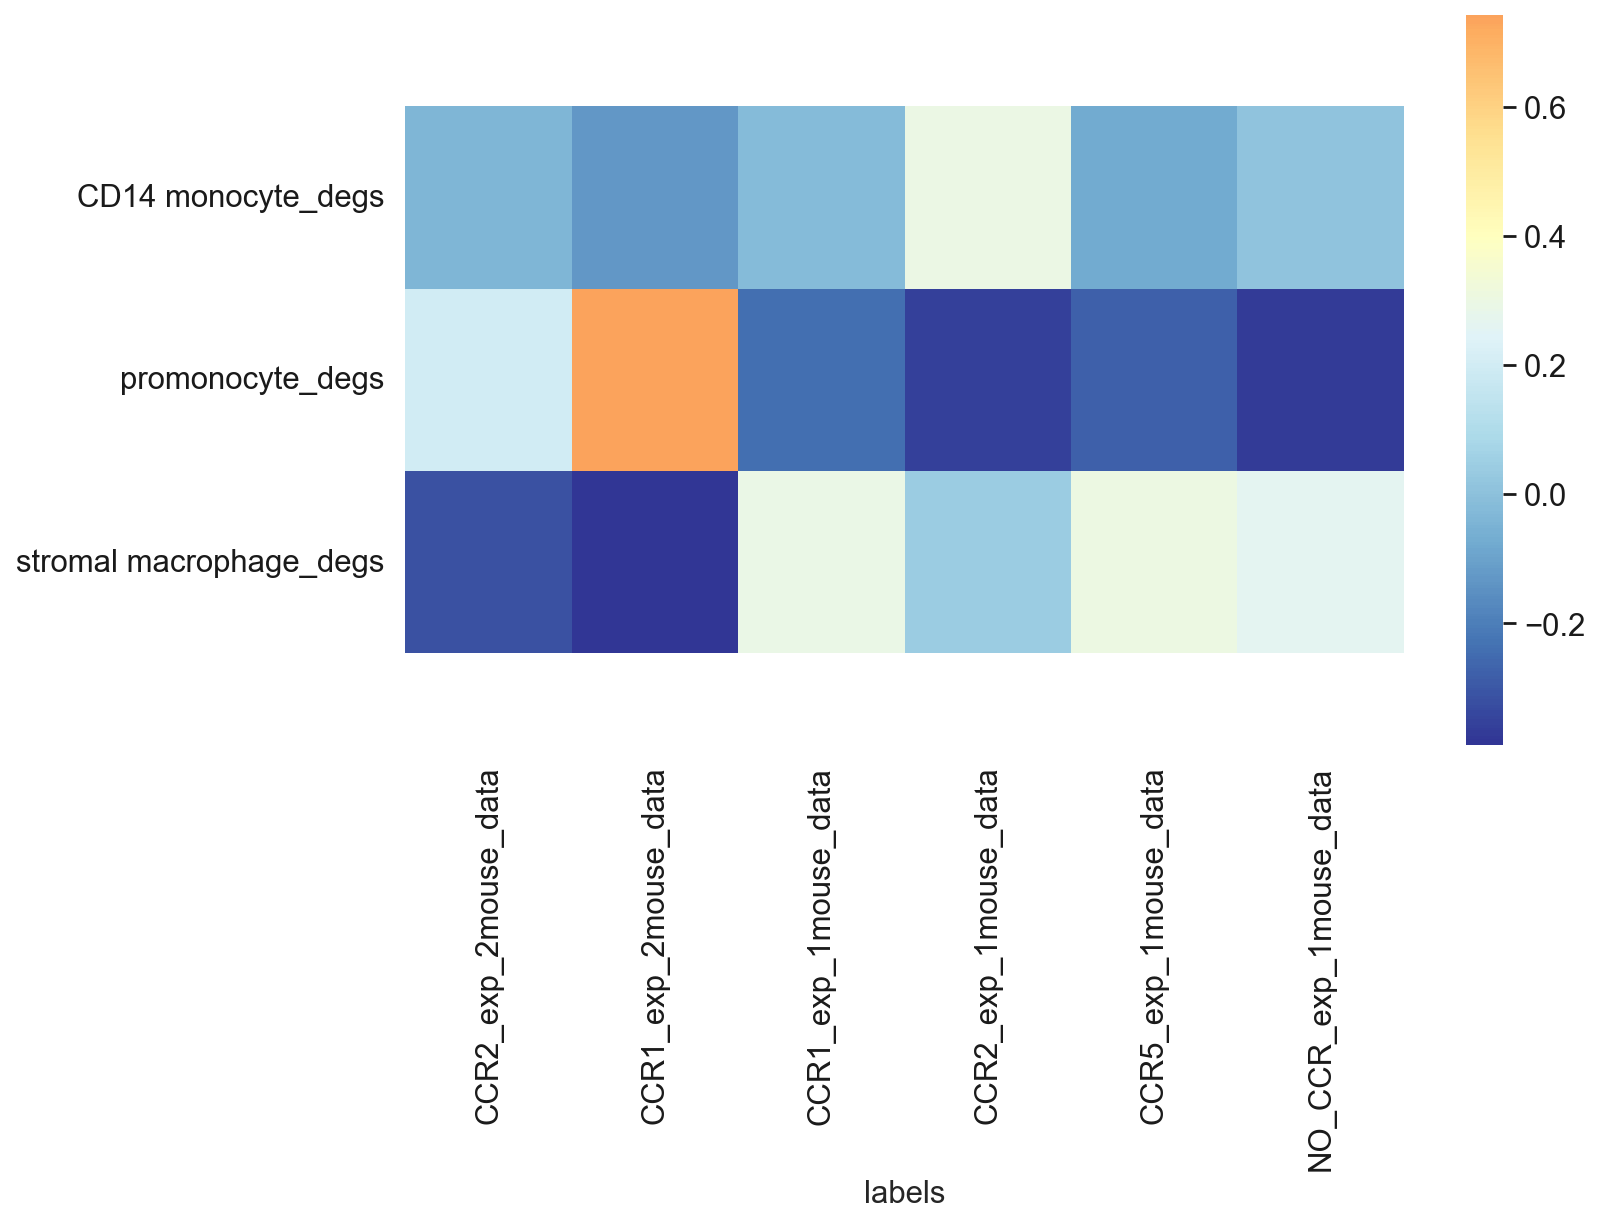

In [47]:
plt.figure(figsize=(10, 6))
fig = sns.heatmap(mean_enrichment_scores_df, cmap="RdYlBu_r", center=0.4).get_figure() 
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
#fig.savefig("figures/figs2e_dc_blood_comparison_numbers_no_20210111.pdf")
fig